## predict redshift using bliss & estimate

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange
import pickle
from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.surveys.dc2 import DC2
from pathlib import Path
from sklearn.metrics import mean_squared_error

environ["BLISS_HOME"] = str(Path().resolve().parents[2])
home = environ["BLISS_HOME"]

output_dir = Path("./DC2_redshift_predict_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [26]:
with initialize(config_path=f".", version_base=None):
    notebook_cfg = compose("notebook_predict_config")

In [13]:
a = torch.randn((6))
a.shape

torch.Size([6])

In [14]:
b = torch.randn((1))
b.shape

torch.Size([1])

In [7]:
torch.cat((a,b), dim=0)

tensor([-0.2613, -1.2093,  0.7137, -1.7870, -1.9117,  1.2654,  0.5172])

In [12]:
torch.Tensor([]).shape

torch.Size([0])

In [10]:
torch.Tensor(1)[0].shape

torch.Size([])

In [27]:
dc2: DC2 = instantiate(notebook_cfg.surveys.dc2)
dc2.setup()
dc2_train_dataset = dc2.train_dataset


# calculate mean of redshift in training set for baseline

In [71]:
redshifts = []
for i in tqdm(range(len(dc2_train_dataset))):
    non_zero_indices = torch.nonzero(dc2_train_dataset[i]['tile_catalog']['redshifts'])
    redshifts += dc2_train_dataset[i]['tile_catalog']['redshifts'][non_zero_indices[:,0], non_zero_indices[:,1], non_zero_indices[:,2], non_zero_indices[:,3]].tolist()
np.mean(redshifts)

1.1343084003841843

In [75]:
true_redshifts = []
for i in tqdm(range(len(dc2.test_dataset))):
    non_zero_indices = torch.nonzero(dc2.test_dataset[i]['tile_catalog']['redshifts'])
    true_redshifts += dc2_train_dataset[i]['tile_catalog']['redshifts'][non_zero_indices[:,0], non_zero_indices[:,1], non_zero_indices[:,2], non_zero_indices[:,3]].tolist()

100%|██████████| 1000/1000 [00:03<00:00, 284.74it/s]


In [77]:
from sklearn.metrics import mean_squared_error
mean_squared_error(true_redshifts, [1.1343084003841843] * len(true_redshifts))

1.2713602425547088

In [49]:
dc2_train_dataset[0]['tile_catalog']['locs'].sum()

tensor(5.8433)

In [39]:
len(dc2_train_dataset)

8000

In [44]:
len(dc2.valid_dataset)

1000

In [40]:
len(dc2.test_dataset)

1000

### Load One Full Image

In [13]:
dc2: DC2 = instantiate(notebook_cfg.surveys.dc2)
test_sample = dc2.get_plotting_sample(0)

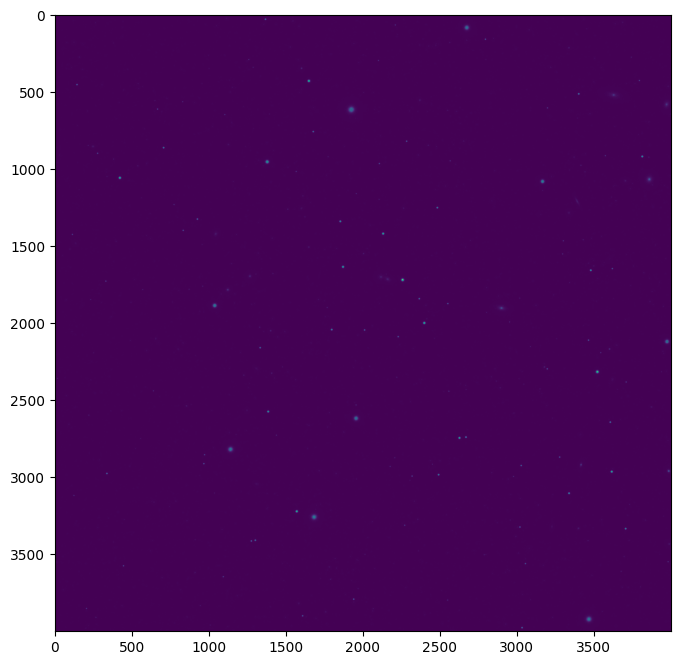

In [14]:
# full image (4000 x 4000)
fig, ax = plt.subplots(figsize=(8, 8))
image = test_sample["image"][0]
ax.imshow(np.log((image - image.min()) + 10), cmap="viridis");

In [15]:
cur_image_wcs = test_sample["wcs"]
cur_image_true_full_catalog = test_sample["full_catalog"]
cur_image_match_id = test_sample["match_id"]

In [16]:
cur_image_true_full_catalog['redshifts'].shape

torch.Size([1, 17093, 1])

### Load the trained model and make prediction

In [18]:
# change this model path according to your training setting
MODEL_PATH = f"{home}/output/DC2_redshift/DC2_redshift_only/checkpoints/encoder_val_loss=0.000000-v11.ckpt"
encoder = instantiate(notebook_cfg.encoder)
pretrained_weights = torch.load(MODEL_PATH)["state_dict"]
encoder.load_state_dict(pretrained_weights)
encoder.eval();

RuntimeError: Error(s) in loading state_dict for MyEncoder:
	Unexpected key(s) in state_dict: "image_normalizer.asinh_thresholds_tensor", "image_normalizer.asinh_scales_tensor". 

In [ ]:
# with open(f"{home}/case_studies/dc2/DC2_exp_output/plotting_model_output.pkl", "rb") as inputp: 
#     out_dict = pickle.load(inputp)

In [ ]:
batch = {
    "tile_catalog": test_sample["tile_catalog"],
    "images": rearrange(test_sample["image"], "h w nw -> 1 h w nw"),
    "background": rearrange(test_sample["background"], "h w nw -> 1 h w nw"),
    "psf_params": rearrange(test_sample["psf_params"], "h w -> 1 h w")
}

with torch.no_grad():
    out_dict = encoder.predict_step(batch, None)

with open(output_dir / "plotting_model_output.pkl", "wb") as outp:  # Overwrites any existing file.
    pickle.dump(out_dict, outp, pickle.HIGHEST_PROTOCOL)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4000 but got size 80 for tensor number 1 in the list.

In [10]:
out_dict

{'mode_cat': TileCatalog(1 x 1000 x 1000),
 'sample_cat': TileCatalog(1 x 1000 x 1000)}

In [11]:
bliss_catalog = out_dict["mode_cat"]
bliss_catalog = bliss_catalog.to_full_catalog(4)
# bliss_catalog.plocs = bliss_catalog.plocs + 4
matcher = instantiate(notebook_cfg.encoder.matcher)
metrics = instantiate(notebook_cfg.encoder.metrics)
matching = matcher.match_catalogs(test_sample["full_catalog"], bliss_catalog)

In [24]:
bliss_catalog["redshift"]

tensor([[[-131.1291],
         [-109.7672],
         [-119.4394],
         ...,
         [-323.6801],
         [-223.2619],
         [-132.0916]]])

In [27]:
matching

[(tensor([   15,    52,    55,  ..., 17052, 17060, 17072]),
  tensor([472295, 483035, 452235,  ...,  86655, 145089, 155193]))]

### Plotting

/tmp/ipykernel_3382958/3296122314.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


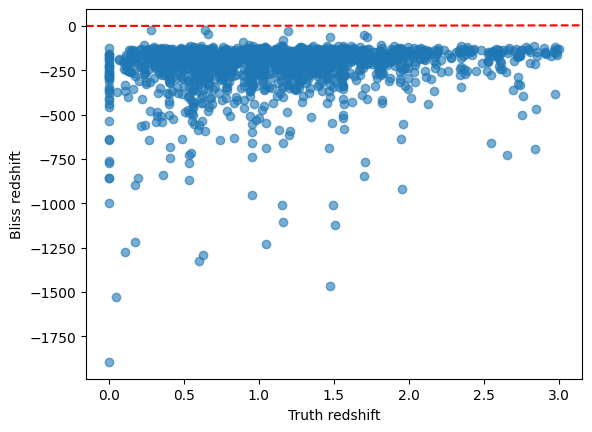

In [36]:
# flux error
true_matches, bliss_matches = matching[0]
# true_flux = cur_image_true_full_catalog.on_nmgy[0, true_matches, :]
# bliss_flux = bliss_catalog.on_nmgy[0, bliss_matches, :]
true_redshift = cur_image_true_full_catalog["redshift"][0, true_matches, :]
bliss_redshift = bliss_catalog.data["redshift"][0, bliss_matches, :]
plt.scatter(
    x = np.array(true_redshift), 
    y = np.array(bliss_redshift), 
    alpha = 0.6,
    cmap = "viridis"
)
# plt.xlim(90, 1000)
plt.ylabel('Bliss redshift')
plt.xlabel('Truth redshift')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
# plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [32]:
true_flux

tensor([[ 133.4033,  449.6573,  339.8168,   40.5279,  583.0919,  522.6511],
        [ 209.0075,  938.2157,  685.0092,   76.2800, 1220.0232, 1104.1008],
        [ 237.6231,  289.7214,  251.7489,  275.3077,  589.6597,  382.0929],
        ...,
        [ 144.8954,  137.3807,  134.9695,  158.5171,  206.0946,  205.2832],
        [ 103.3476,  488.2363,  224.0511,   82.9568, 1680.4921, 1006.5674],
        [ 173.0807,  163.0257,  146.0339,  160.5083,  198.3755,  181.6145]])

In [15]:
len(bliss_redshift)

1692

In [39]:
mse = mean_squared_error(true_redshift, bliss_redshift)
print(f"mse:{mse:03f}")

mse:76338.794526
